<a href="https://colab.research.google.com/github/fahriyegrl/NJIT_RNN_Computer_Vision_Assignment/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.16.0
    Uninstalling jupyter-server-1.16.0:
      Successfully uninstalled jupyter-server-1.1

In [2]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

# <font color = 'blue'>   **Assignment 5**


In this assignment we will do some exercises with material from recurrent neural networks and computer vision.

## <font color = 'blue'>   **Question 1**

<font color = 'blue'>  [Chapter 13.12](https://classic.d2l.ai/chapter_computer-vision/neural-style.html) of the previous-version textbook discusses neural style transfer. In the cells below copy the appropriate cells from that notebook and apply it to some images of your choice. Show your work, and post it on the discussion board of the last week of the course.

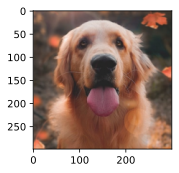

In [4]:

d2l.set_figsize()
content_img = d2l.Image.open('/content/content_img.jpg')
d2l.plt.imshow(content_img);

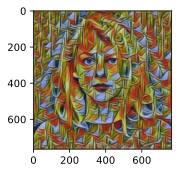

In [5]:
style_img = d2l.Image.open('/content/style_img.png')
style_img = style_img.convert('RGB')
d2l.plt.imshow(style_img);

In [6]:
### I got the below codes until Question-2 from the link - https://www.google.com/url?q=https%3A%2F%2Fclassic.d2l.ai%2Fchapter_computer-vision%2Fneural-style.html
### And I applied the pictures I chose above.

In [8]:
###-1 Preprocessing and Postprocessing
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

In [10]:
###-2 Extracting Features
import torchvision
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [11]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

In [12]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

In [13]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [14]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [15]:
###-3 Defining the Loss Function
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

In [16]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)


def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [17]:
###-4 Total Variation Loss
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [18]:
###-5 Loss Function

content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

In [19]:
###-6 Initializing the Synthesized Image
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [20]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [21]:
###-7 Training

def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

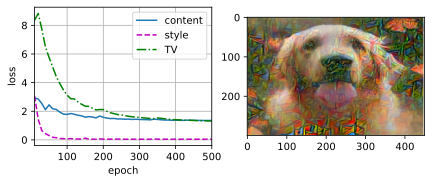

In [22]:
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

## <font color = 'blue'>   **Question 2**

<font color = 'blue'> Experiment with the settings of the neural style transfer model from the previous question. What happens if you change the designated 'content' and 'style' layers. Demonstrate your work and provide a thorough description.
<font color = 'blue'>  

In [ ]:
### The current setup : style_layers, content_layers = [0, 5, 10, 19, 28], [25]
### I am going to change the setup to
   ## Fewer layers on style_layers = [0, 5, 10])
   ##  More layes on content_layers = [10]
   ## style_layers = [19, 28]

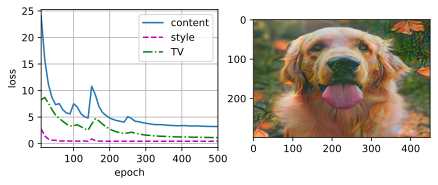

In [23]:
## Experiment -1

style_layers, content_layers = [0, 5, 10, 19, 28], [10]
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

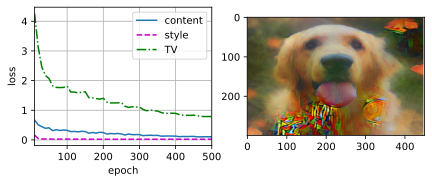

In [24]:
## Experiment -2

style_layers, content_layers =  [0, 5, 10], [25]
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

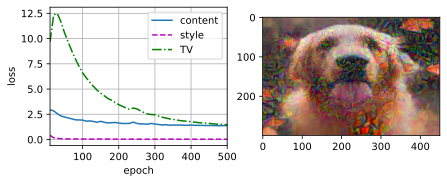

In [25]:
## Experiment -3
style_layers, content_layers = [19, 28], [25]
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

In [26]:
# Experiment 1: the model tries to preserve finer spatial details and textures from the content image.
# Experiment 2: the model mostly capture color, texture, edges, but not higher-level structure.
# Experiment 3: the model capture semantic style—structure, layout, and abstract forms but missing fine texture.

## <font color = 'blue'>   **Question 3**

<font color = 'blue'> In [Chapter 8.1](https://classic.d2l.ai/chapter_recurrent-neural-networks/index.html) of the 'classic' version of the book, we saw a task of predicting a simple time series with a standard regression model. Based on that notebook, replace the simple regression model with an RNN architecture using GRU or LSTMS units. Discuss how your model works and its hyperparameters.





In [ ]:
### I got the data from the Chapter 8.1 that is used in the regression model.

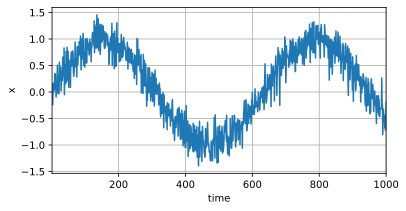

In [27]:
####  Implementing GRU

import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # Total time steps
tau = 4  # Number of past steps used for prediction

time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))  # Generate time series data

d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))


In [28]:
# Reshape input for RNN (batch_size, sequence_length, features)
features = torch.zeros((T - tau, tau, 1))
labels = x[tau:].reshape((-1, 1))

for i in range(tau):
    features[:, i, 0] = x[i: T - tau + i]

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [29]:
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(10, 1)  # Fully connected layer for output

    def forward(self, X):
        output, _ = self.gru(X)  # GRU outputs (batch_size, sequence_length, hidden_size)
        return self.fc(output[:, -1, :])  # Use last time step's output


In [30]:
def train_gru(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)  # Forward pass
            l = loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = GRUModel()
loss = nn.MSELoss()
train_gru(net, train_iter, loss, epochs=5, lr=0.01)


epoch 1, loss: 0.050569
epoch 2, loss: 0.052405
epoch 3, loss: 0.050575
epoch 4, loss: 0.051135
epoch 5, loss: 0.049475


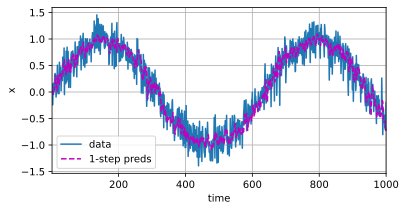

In [32]:
onestep_preds = net(features).detach()

# Plot results
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))


In [34]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, num_layers=1, batch_first=True)
        self.fc = nn.Linear(10, 1)  # Fully connected layer for output

    def forward(self, X):
        output, _ = self.lstm(X)  # LSTM returns (output, (h_n, c_n))
        return self.fc(output[:, -1, :])  # Use last time step’s output


In [35]:
def train_lstm(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            y_hat = net(X)  # Forward pass
            l = loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = LSTMModel()
loss = nn.MSELoss()
train_lstm(net, train_iter, loss, epochs=5, lr=0.01)


epoch 1, loss: 0.066204
epoch 2, loss: 0.051698
epoch 3, loss: 0.051054
epoch 4, loss: 0.050172
epoch 5, loss: 0.051774


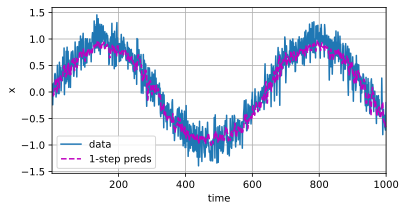

In [36]:
onestep_preds = net(features).detach()

d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.numpy()],
         'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))


In [38]:
### I used the same parameters as the original model has for GRU and LTSM.
### The loss results from GRU model are quite similar to the LSTM model.
###  GRU is showing a more stable or efficient learning compared to LSTM.
### The original model from chapter 8.1  struggle more with time-series data compared to LSTM/GRU due to lack of memory in sequential tasks.